In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle
!kaggle datasets download -d dschettler8845/brats-2021-task1

Dataset URL: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
License(s): copyright-authors
 46% 5.68G/12.3G [06:00<06:59, 16.9MB/s]
User cancelled operation


In [ ]:
"!unzip /content/brats-2021-task1.zip"

Archive:  /content/brats-2021-task1.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/brats-2021-task1.zip or
        /content/brats-2021-task1.zip.zip, and cannot find /content/brats-2021-task1.zip.ZIP, period.


In [ ]:
!tar -xvf /content/BraTS2021_Training_Data.tar -C /content/drive/MyDrive/kaggle/Training/

tar: /content/BraTS2021_Training_Data.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
import keras
import random
policy = tf.keras.mixed_precision.Policy("float32")
tf.keras.mixed_precision.set_global_policy(policy)

import warnings
warnings.filterwarnings('ignore')


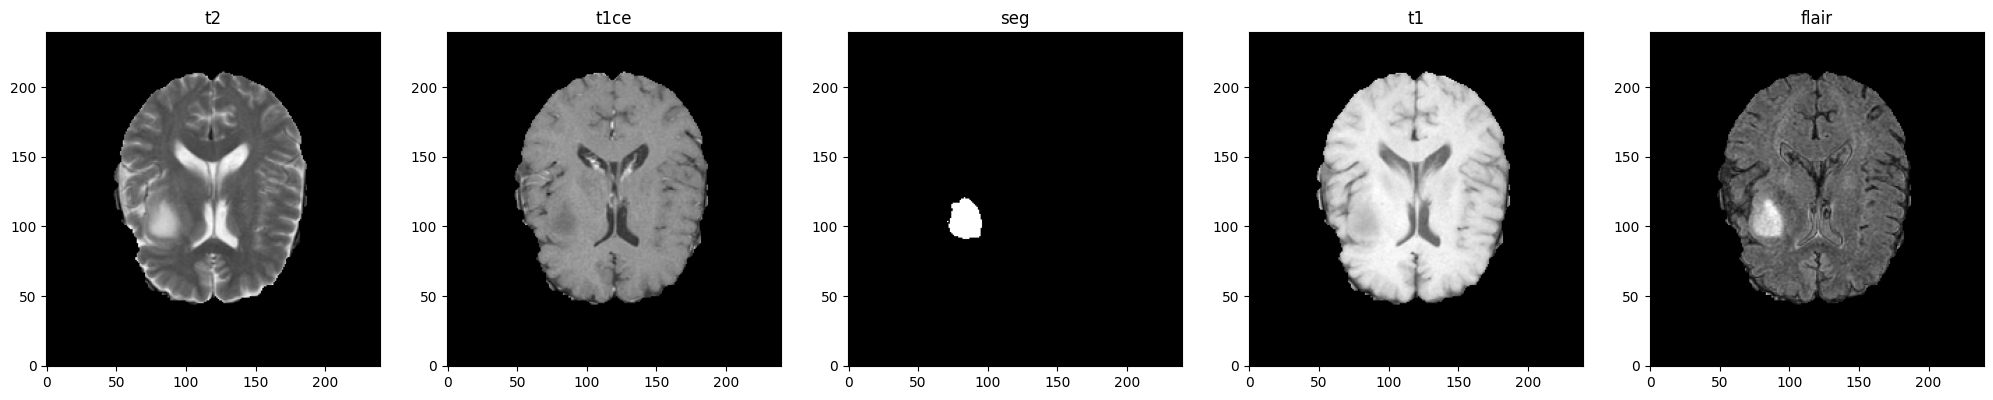

In [ ]:
file_path = "/content/drive/MyDrive/kaggle/Training"

fig,axes = plt.subplots(1,5, figsize=(25,10))
a = np.random.randint(1,100)
#for i in (os.listdir(file_path)):
i = os.path.join(file_path, (os.listdir(file_path)[10]))
subpath = i
for x, j in enumerate(os.listdir(subpath)):
    scans = (j.split("_"))[2][:-7] # to get label from filename
    img = nib.load(os.path.join(subpath,j))
    data = img.get_fdata()
     #cropping into 128x128x128 shape
    # Choose a slice in the middle of the volume
    slice_index = data.shape[2] // 2
    axes[x].imshow(data[:, :, slice_index].T, cmap='gray', origin='lower')
    axes[x].set_title(scans)

    # Show the plot
plt.show()

In [ ]:
def generator(base_path, patient_list, batch_size):
    L = len(patient_list)
    random.shuffle(patient_list) #shuffle after each epoch

    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            X, Y = load_images(base_path, patient_list[batch_start:batch_end])

            yield(X, Y)

            batch_start += batch_size
            batch_end += batch_size


def load_images(base_path, patient_list):
    images = []
    segmentation = []
    scaler = MinMaxScaler()
    for patient in patient_list:
        patient_path = os.path.join(base_path, patient)
        t1ce_path = os.path.join(patient_path,f"{patient}_t1ce.nii.gz")
        t2_path = os.path.join(patient_path,f"{patient}_t2.nii.gz")
        flair_path = os.path.join(patient_path,f"{patient}_flair.nii.gz")
        seg_path = os.path.join(patient_path,f"{patient}_seg.nii.gz")

        t1ce = np.array(nib.load(t1ce_path).get_fdata()).astype(np.float32)
        t1ce = scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
        t1ce = t1ce[56:184, 56:184,14:142]

        t2 = np.array(nib.load(t2_path).get_fdata()).astype(np.float32)
        t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
        t2 = t2[56:184, 56:184,14:142]

        flair = np.array(nib.load(flair_path).get_fdata()).astype(np.float32)
        flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
        flair = flair[56:184, 56:184,14:142]

        seg = np.array(nib.load(seg_path).get_fdata())
        seg[seg == 4] = 3
        seg = seg.astype(np.uint8)
        seg = seg[56:184, 56:184,14:142]
        seg = to_categorical(seg, num_classes=4)

        combined = np.stack([t1ce, t2, flair], axis=-1)

        images.append(combined)
        segmentation.append(seg)

    images = np.array(images)
    segmentation = np.array(segmentation)

    return images, segmentation


In [ ]:
file_path = "/content/drive/MyDrive/kaggle/Training"
patients = os.listdir(file_path)

#train and validation split
from sklearn.model_selection import train_test_split
train, validation = train_test_split(patients, test_size=0.2, random_state=42)

In [ ]:
os.path.join(file_path, train[0])

'/content/drive/MyDrive/kaggle/Training/BraTS2021_00199'

In [ ]:
batch_size = 8
train_generator = generator(file_path, train, batch_size=batch_size)
val_generator = generator(file_path, validation, batch_size=batch_size)

In [ ]:
def encoder(input_tensor, n_filters, kernel_size=(3,3,3)):
  x = layers.Conv3D(n_filters, kernel_size, padding='same')(input_tensor)
  x = layers.GroupNormalization(groups=2)(x)
  x = layers.ReLU()(x)

  x = layers.Conv3D(n_filters, kernel_size, padding='same')(input_tensor)
  x = layers.GroupNormalization(groups=2)(x)

  residual = layers.Conv3D(n_filters, kernel_size=(1,1,1), padding='same')(input_tensor)
  x = layers.add([x, residual])

  x = layers.ReLU()(x)

  #can add residual

  return x

def AttentionGate(input_tensor, n_filters, gating_signal):
  ds_x = layers.Conv3D(n_filters, (2,2,2), strides=(2,2,2), padding='same')(input_tensor) #matching dimesion to gating signal
  ds_gate = layers.Conv3D(n_filters,(1,1,1), padding='same')(gating_signal) #not necessary, just to match dimension to input tensor

  #addition and relu
  add_xgate = layers.add([ds_x, ds_gate])
  relu_xgate = layers.ReLU()(add_xgate)

  #conv and sigmoid operations to capture features
  psi = layers.Conv3D(1, (1,1,1), padding='same')(relu_xgate)
  sig = layers.Activation('sigmoid')(psi)

  #upsample to gating signal's original dimensions
  resampler = layers.UpSampling3D(size=(2,2,2))(sig)

  #attention output
  output = layers.multiply([input_tensor, resampler])

  return output

In [ ]:
def build_model(input_shape=(128,128,128,3), n_classes=4):
  inputs = layers.Input(input_shape)

  #4 layers of encoder
  e1 = encoder(inputs, 16, (3,3,3))
  p1 = layers.MaxPooling3D(pool_size=(2,2,2))(e1)

  e2 = encoder(p1, 32, (3,3,3))
  p2 = layers.MaxPooling3D(pool_size=(2,2,2))(e2)

  e3 = encoder(p2, 64, (3,3,3))
  p3 = layers.MaxPooling3D(pool_size=(2,2,2))(e3)

  #bottleneck
  e4 = encoder(p3, 128, (3,3,3))
  p4 = layers.MaxPooling3D(pool_size=(2,2,2))(e4)

  e5 = encoder(p4, 256, (3,3,3))

  #attention gates and upsampling
  a1 = AttentionGate(e4, 128, e5)
  u1 = layers.Conv3DTranspose(128, (2,2,2), strides=(2,2,2), padding='same')(e5)
  u1 = layers.concatenate([a1,u1])
  e7 = encoder(u1, 128)

  a2 = AttentionGate(e3, 64, e4)
  u2 = layers.Conv3DTranspose(64, (2,2,2), strides=(2,2,2), padding='same')(e4)
  u2 = layers.concatenate([a2,u2])
  e7 = encoder(u2, 64)

  a3 = AttentionGate(e2, 32, e7)
  u3 = layers.Conv3DTranspose(32, (2,2,2), strides=(2,2,2), padding='same')(e7)
  u3 = layers.concatenate([a3,u3])
  e8 = encoder(u3,32)

  a4 = AttentionGate(e1, 16, e8)
  u4 = layers.Conv3DTranspose(16, (2,2,2), strides=(2,2,2), padding='same')(e8)
  u4 = layers.concatenate([a4, u4])
  e9 = encoder(u4, 16)


  #output
  outputs = layers.Conv3D(n_classes, (1,1,1), activation='softmax')(e9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

@tf.keras.utils.register_keras_serializable()
def per_class_dice(class_index):
    def dice(y_true, y_pred):
        # Convert the true labels to a one-hot encoding (if needed)
        y_true_class = tf.cast(tf.equal(tf.argmax(y_true, axis=-1), class_index), tf.float32)

        # Convert the predicted labels to a one-hot encoding
        y_pred_class = tf.cast(tf.equal(tf.argmax(y_pred, axis=-1), class_index), tf.float32)

        # Flatten the arrays
        y_true_f = tf.keras.backend.flatten(y_true_class)
        y_pred_f = tf.keras.backend.flatten(y_pred_class)

        # Calculate intersection and Dice coefficient
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6)

    return dice



In [ ]:
"""model = build_model((128,128,128,3),4)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics=[iou, per_class_dice(1), per_class_dice(2), per_class_dice(3)])
callbacks = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/brain.keras', verbose=1, save_best_only=True,monitor='loss')"""

"model = build_model((128,128,128,3),4)\nmodel.summary()\nmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics=[iou, per_class_dice(1), per_class_dice(2), per_class_dice(3)])\ncallbacks = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/brain.keras', verbose=1, save_best_only=True,monitor='loss')"

In [ ]:
model = keras.saving.load_model('/content/drive/MyDrive/Colab Notebooks/brain.keras')
callbacks = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/brain.keras', verbose=1, save_best_only=True,monitor='loss')

In [ ]:
steps_per_epoch = len(train)//batch_size
val_per_epoch = len(validation)//batch_size
history = model.fit(train_generator, epochs=50, verbose=1, validation_data=val_generator,
                       steps_per_epoch= steps_per_epoch, validation_steps=val_per_epoch, callbacks=callbacks)

Epoch 1/50
  6/125 ━━━━━━━━━━━━━━━━━━━━ 1:35:58 48s/step - dice: 0.0188 - dice_1: 0.0188 - dice_2: 0.0188 - iou: 0.9632 - loss: 0.0346